In [7]:
# Here we are importing the necessary libraries
from __future__ import print_function
from __future__ import division
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
import torch.optim as optim
#This is for Google Collab Notebook - it doesn't have torchplot installed!
#!pip install torchplot
import torchplot as tplt

from torch import nn
from torch import optim
from torchvision import datasets, models, transforms
from torchvision import transforms as T
from tqdm import tqdm
from torch.utils.data import DataLoader, sampler, random_split

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We will be using the:", device)

PyTorch Version:  1.10.2
Torchvision Version:  0.11.3
We will be using the: cpu


In [8]:
transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize(28),
            transforms.CenterCrop(28),
            transforms.ToTensor(),
            #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
emnist_dataset = datasets.EMNIST(root='./', split='letters', train=True, download=True, transform=transform,)
#all_data = datasets.ImageFolder('../input/handwritten-math-symbols/dataset', transform=transform)
all_data = datasets.ImageFolder('./CustomArchive/dataset', transform=transform)

image_datasets = torch.utils.data.ConcatDataset([all_data, emnist_dataset])
train_data = DataLoader(all_data,batch_size=10,)

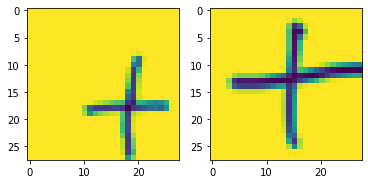

In [9]:
import matplotlib.pyplot as plt
data = iter(train_data) # Let's iterate on it
single_point = next(data)
ToPIL = T.ToPILImage() # Converting function
img0 = ToPIL(single_point[0][0])
img1 = ToPIL(single_point[0][1])
# Plotting
fig, axs = plt.subplots(1,2)
axs[0].imshow(img0)
axs[1].imshow(img1)

In [10]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6,5,padding=2)
        self.conv2 = nn.Conv2d(6,16,5, padding=0)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,62)
        
    def forward(self, x):
        x = torch.sigmoid(self.conv1(x))
        x =  nn.MaxPool2d(kernel_size=2, stride=2)(x)
        x = torch.sigmoid(self.conv2(x))
        x =  nn.MaxPool2d(kernel_size=2, stride=2)(x)
        
        x = x.view(-1, 5*5*16)
        
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
# Let's set up some parameters
learning_rate=0.001
nepochs = 8
ninputs=1*28*28
nout=53

#model = AlexNet().to(device)
model = LeNet().to(device)

print(model)

# We need an optimizer that tells us what form of gradient descent to do
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

# We also need a loss function
LossFunction = nn.CrossEntropyLoss()

batch_size = 64

transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize(28),
            transforms.CenterCrop(28),
            transforms.ToTensor(),
            #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])


emnist_dataset = datasets.EMNIST(root='./', split='bymerge', train=True, download=True, transform=transform,)
emnist_test_dataset = datasets.EMNIST(root='./', split='bymerge', train=False, download=False, transform=transform,)
#operator_dataset = datasets.ImageFolder('../input/handwritten-math-symbols/dataset', transform=transform)
operator_dataset = datasets.ImageFolder('./CustomArchive/dataset', transform=transform)


train_operator_data_len = int(len(operator_dataset)*0.70)
test_operator_data_len = int(len(operator_dataset) - train_operator_data_len)
operator_train_data, operator_test_data = random_split(operator_dataset, [train_operator_data_len, test_operator_data_len])

train_image_datasets = torch.utils.data.ConcatDataset([operator_train_data, emnist_dataset])
train_data = DataLoader(train_image_datasets,batch_size=batch_size,shuffle=True)

test_image_datasets = torch.utils.data.ConcatDataset([operator_test_data, emnist_test_dataset])
test_data = DataLoader(test_image_datasets,batch_size=batch_size,shuffle=True)

# This is default on but let's just be pedantic
model.train()
loss_history = []
test_accuracy_history = []
train_accuracy_history = []
loss = torch.Tensor([0])
for epoch in tqdm(range(nepochs), desc=f"Epoch", unit="epoch", disable=False):
    accuracy = 0
    for (data, label) in tqdm(train_data, desc="iteration", unit="%", disable=True):
        # Here we clear the gradients
        optimizer.zero_grad(set_to_none=True)
        
        # We need to make sure the tensors are on the same device as our model
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        
        loss = LossFunction(out, label)
        
        loss.backward() # This function calculates all our gradients
        optimizer.step() # This function does our gradient descent with those gradients
        loss_history.append(loss.item())
        answers = out.max(dim=1)[1]
        accuracy += (answers == label).sum()
    # Append the training accuracy
    accuracy = accuracy / len(train_image_datasets)*100
    train_accuracy_history.append(accuracy)
    
    #let's get the test accuracy to see how well it generalizes
    test_accuracy = 0
    for (data, label) in test_data:
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        answers = out.max(dim=1)[1]
        test_accuracy += (answers == label).sum()
    # Append the testing accuracy
    test_accuracy = test_accuracy / len(test_image_datasets)*100
    test_accuracy_history.append(test_accuracy)
    #Print the results
    print(f"Epoch: {epoch} \n Loss: {loss.item()} \n Train Accuracy: {accuracy:.2f}% \n Test Accuracy: {test_accuracy:.2f}%")


LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=62, bias=True)
)


Epoch:  10%|███████                                                               | 1/10 [12:23<1:51:35, 743.90s/epoch]

Epoch: 0 
 Loss: 0.39201003313064575 
 Train Accuracy: 74.00% 
 Test Accuracy: 84.81%


Epoch:  20%|██████████████                                                        | 2/10 [24:05<1:37:29, 731.18s/epoch]

Epoch: 1 
 Loss: 0.2936874032020569 
 Train Accuracy: 86.79% 
 Test Accuracy: 87.35%


Epoch:  30%|█████████████████████                                                 | 3/10 [37:08<1:27:06, 746.67s/epoch]

Epoch: 2 
 Loss: 0.5168955326080322 
 Train Accuracy: 87.98% 
 Test Accuracy: 88.18%


Epoch:  40%|████████████████████████████                                          | 4/10 [51:25<1:17:59, 779.90s/epoch]

Epoch: 3 
 Loss: 0.4099850356578827 
 Train Accuracy: 88.55% 
 Test Accuracy: 88.35%


Epoch:  50%|██████████████████████████████████                                  | 5/10 [1:05:56<1:07:16, 807.23s/epoch]

Epoch: 4 
 Loss: 0.30793917179107666 
 Train Accuracy: 88.93% 
 Test Accuracy: 88.70%


Epoch:  60%|██████████████████████████████████████████                            | 6/10 [1:13:12<46:22, 695.68s/epoch]

Epoch: 5 
 Loss: 0.20479317009449005 
 Train Accuracy: 89.18% 
 Test Accuracy: 88.75%


Epoch:  70%|█████████████████████████████████████████████████                     | 7/10 [1:19:06<29:39, 593.31s/epoch]

Epoch: 6 
 Loss: 0.2444828897714615 
 Train Accuracy: 89.41% 
 Test Accuracy: 88.94%


Epoch:  80%|████████████████████████████████████████████████████████              | 8/10 [1:24:17<16:56, 508.49s/epoch]

Epoch: 7 
 Loss: 0.18336211144924164 
 Train Accuracy: 89.56% 
 Test Accuracy: 89.07%


Epoch:  90%|███████████████████████████████████████████████████████████████       | 9/10 [1:30:17<07:44, 464.02s/epoch]

Epoch: 8 
 Loss: 0.12969070672988892 
 Train Accuracy: 89.69% 
 Test Accuracy: 89.05%


Epoch: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [1:35:26<00:00, 572.65s/epoch]

Epoch: 9 
 Loss: 0.18048860132694244 
 Train Accuracy: 89.84% 
 Test Accuracy: 89.25%


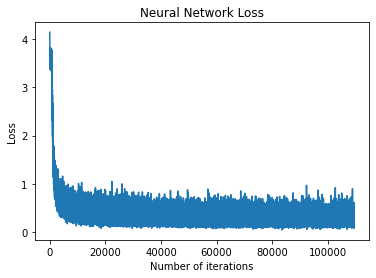

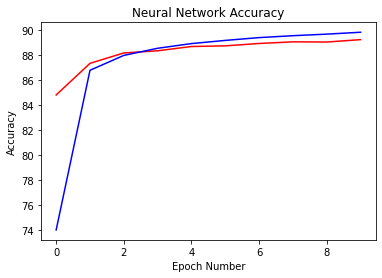

In [13]:
# Plot the loss per iteration
plt.plot(loss_history)
plt.title("Neural Network Loss")
plt.xlabel("Number of iterations")
plt.ylabel("Loss")
plt.show()
# Plot the accuracy per epoch
tplt.plot(test_accuracy_history, 'r')
tplt.plot(train_accuracy_history, 'b')
tplt.title("Neural Network Accuracy")
tplt.xlabel("Epoch Number")
tplt.ylabel("Accuracy")
tplt.show()